# CatBoost Starter for Brain Comp
EEGの差分の集計特徴量を用いたNotebook。

- ver1: CV , LB 

### Version Notes
- Version 1 - EEGのT=20, 30, 40秒における、10秒時間窓 / 20秒時間窓のmean, min, max, std, max-minを特徴量とした

# Load Libraries

In [5]:
import os, gc
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"
import pandas as pd
import numpy as np
import polars as pl
import matplotlib.pyplot as plt

VER = 2

# Load Train Data

In [6]:
df_train = pl.read_csv('../input/hms-harmful-brain-activity-classification/train.csv')
TARGETS = df_train.columns[-6:]
print('Train shape:', df_train.shape )
print('Targets', list(TARGETS))
df_train.head()

Train shape: (106800, 15)
Targets ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']


eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
i64,i64,f64,i64,i64,f64,i64,i64,str,i64,i64,i64,i64,i64,i64
1628180742,0,0.0,353733,0,0.0,127492639,42516,"""Seizure""",3,0,0,0,0,0
1628180742,1,6.0,353733,1,6.0,3887563113,42516,"""Seizure""",3,0,0,0,0,0
1628180742,2,8.0,353733,2,8.0,1142670488,42516,"""Seizure""",3,0,0,0,0,0
1628180742,3,18.0,353733,3,18.0,2718991173,42516,"""Seizure""",3,0,0,0,0,0
1628180742,4,24.0,353733,4,24.0,3080632009,42516,"""Seizure""",3,0,0,0,0,0


# Create Multiple Eeg Id Train Data
データの説明[here][1]には、テストデータには、同じ `eeg_id` からの複数の crop は含まれていないと記載されている。<br>
ひとつの`eeg_id`ごとのデータにする

[1]: https://www.kaggle.com/competitions/hms-harmful-brain-activity-classification/discussion/467021

In [7]:
df_train = df_train.group_by(by = 'eeg_id').agg(
    pl.min("eeg_label_offset_seconds").alias("eeg_min_offset"),
    pl.max("eeg_label_offset_seconds").alias("eeg_max_offset"),
    pl.first("patient_id"),
    pl.sum("seizure_vote"),
    pl.sum("lpd_vote"),
    pl.sum("gpd_vote"),
    pl.sum("lrda_vote"),
    pl.sum("grda_vote"),
    pl.sum("other_vote"),
    pl.first("expert_consensus")
)
df_train.head()


# 各vote列の合計
df_train = df_train.with_columns(
    (pl.col('seizure_vote') + pl.col('lpd_vote') + pl.col('gpd_vote') + pl.col('lrda_vote') + pl.col('grda_vote') + pl.col('other_vote')).alias('vote_sum')
)

# 各vote列の正規化
df_train = df_train.with_columns(
    (pl.col('seizure_vote') / pl.col('vote_sum')).alias('seizure_vote'),
    (pl.col('lpd_vote') / pl.col('vote_sum')).alias('lpd_vote'),
    (pl.col('gpd_vote') / pl.col('vote_sum')).alias('gpd_vote'),
    (pl.col('lrda_vote') / pl.col('vote_sum')).alias('lrda_vote'),
    (pl.col('grda_vote') / pl.col('vote_sum')).alias('grda_vote'),
    (pl.col('other_vote') / pl.col('vote_sum')).alias('other_vote'),
)

# vote列の削除
df_train = df_train.drop(["vote_sum"])

# expert_consensus列をtarget列とする
df_train = df_train.rename({"expert_consensus": "target"})
df_train.head()

eeg_id,eeg_min_offset,eeg_max_offset,patient_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,target
i64,f64,f64,i64,f64,f64,f64,f64,f64,f64,str
2191916085,0.0,24.0,28121,0.055556,0.0,0.0,0.0,0.0,0.944444,"""Other"""
1803582899,0.0,0.0,60160,0.0,0.0,0.0,0.0,0.0,1.0,"""Other"""
3641000027,0.0,0.0,49713,0.0,1.0,0.0,0.0,0.0,0.0,"""LPD"""
239454973,0.0,4.0,12251,0.133333,0.0,0.2,0.0,0.0,0.666667,"""Other"""
2310431472,0.0,0.0,37979,0.0,0.0,0.0,1.0,0.0,0.0,"""LRDA"""


# Feature Engineer


CatBoostモデルに入れる特徴量を作成する。


In [8]:
PATH = '../input/hms-harmful-brain-activity-classification/train_eegs/'
files = os.listdir(PATH)
print(f'There are {len(files)} eeg parquet files')

all_eegs = {}
temp = pl.DataFrame()
for i, f in enumerate(files):
    if i%100 == 0: print(i, ', ', end = '')

    eeg_id = int(f.split('.')[0])    

    temp_eeg = pl.read_parquet(f'{PATH}{f}')

    # eegデータにおける、計測開始から各行までの秒数 seconds_eeg
    t = 1/200 # EEGのサンプリング周波数は200Hzなので、1行は1/200秒ごとの計測値を表す  
    seconds = [i*t for i in range(len(temp_eeg))]
    max_second = max(seconds)
    temp_eeg = temp_eeg.with_columns(pl.Series(seconds).alias("seconds_eeg")) 
    

    # 差分特徴量を作る
    temp_eeg = temp_eeg.with_columns(
        (pl.col("Fp1") - pl.col("T3")).alias("LL_Fp1-T3"),
        (pl.col("T3") - pl.col("O1")).alias("LL_T3-O1"),
        (pl.col("Fp1") - pl.col("C3")).alias("LP_Fp1-C3"),
        (pl.col("C3") - pl.col("O1")).alias("LP_C3-O1"),
        (pl.col("Fp2") - pl.col("C4")).alias("RP_Fp2-C4"),
        (pl.col("C4") - pl.col("O2")).alias("RP_C4-O2"),
        (pl.col("Fp2") - pl.col("T4")).alias("RR_Fp2-T4"),
        (pl.col("T4") - pl.col("O2")).alias("RR_T4-O2"),
    )

    # 差分特徴量の集計特徴量をつくる
    # window = 4000 # 20秒窓 (20秒 / (1レコード1/200秒) = 4000レコード)
    window_list = [1000, 2000]

    for window in window_list:

        str_window = str(int(window / (200))) + "s"
        temp_eeg = temp_eeg.with_columns(
            # LL: Fp1 - T3
            pl.col("LL_Fp1-T3").rolling_mean(window_size=window, center=True).alias("mean_" + str_window + "_LL_Fp1-T3"),
            pl.col("LL_Fp1-T3").rolling_max(window_size=window, center=True).alias("min_" + str_window + "_LL_Fp1-T3"),
            pl.col("LL_Fp1-T3").rolling_min(window_size=window, center=True).alias("max_" + str_window + "_LL_Fp1-T3"),
            pl.col("LL_Fp1-T3").rolling_std(window_size=window, center=True).alias("std_" + str_window + "_LL_Fp1-T3"),
            (pl.col("LL_Fp1-T3").rolling_max(window_size=window, center=True) - pl.col("LL_Fp1-T3").rolling_min(window_size=window, center=True)).alias("max-min_" + str_window + "_LL_Fp1-T3"),

            # LL: Fp1 - T3
            pl.col("LL_T3-O1").rolling_mean(window_size=window, center=True).alias("mean_" + str_window + "_LL_T3-O1"),
            pl.col("LL_T3-O1").rolling_max(window_size=window, center=True).alias("min_" + str_window + "_LL_T3-O1"),
            pl.col("LL_T3-O1").rolling_min(window_size=window, center=True).alias("max_" + str_window + "_LL_T3-O1"),
            pl.col("LL_T3-O1").rolling_std(window_size=window, center=True).alias("std_" + str_window + "_LL_T3-O1"),
            (pl.col("LL_T3-O1").rolling_max(window_size=window, center=True) - pl.col("LL_T3-O1").rolling_min(window_size=window, center=True)).alias("max-min__" + str_window + "_LL_T3-O1"),


            # LP: Fp1 - C3
            pl.col("LP_Fp1-C3").rolling_mean(window_size=window, center=True).alias("mean_" + str_window + "_LP_Fp1-C3"),
            pl.col("LP_Fp1-C3").rolling_max(window_size=window, center=True).alias("min_" + str_window + "_LP_Fp1-C3"),
            pl.col("LP_Fp1-C3").rolling_min(window_size=window, center=True).alias("max_" + str_window + "_LP_Fp1-C3"),
            pl.col("LP_Fp1-C3").rolling_std(window_size=window, center=True).alias("std_" + str_window + "_LP_Fp1-C3"),
            (pl.col("LP_Fp1-C3").rolling_max(window_size=window, center=True) - pl.col("LP_Fp1-C3").rolling_min(window_size=window, center=True)).alias("max-min_" + str_window + "_LP_Fp1-C3"),

            # LP: C3 - O1
            pl.col("LP_C3-O1").rolling_mean(window_size=window, center=True).alias("mean_" + str_window + "_LP_C3-O1"),
            pl.col("LP_C3-O1").rolling_max(window_size=window, center=True).alias("min_" + str_window + "_LP_C3-O1"),
            pl.col("LP_C3-O1").rolling_min(window_size=window, center=True).alias("max_" + str_window + "_LP_C3-O1"),
            pl.col("LP_C3-O1").rolling_std(window_size=window, center=True).alias("std_" + str_window + "_LP_C3-O1"),
            (pl.col("LP_C3-O1").rolling_max(window_size=window, center=True) - pl.col("LP_C3-O1").rolling_min(window_size=window, center=True)).alias("max-min_" + str_window + "_LP_C3-O1"),


            # RP: Fp1 - C4
            pl.col("RP_Fp2-C4").rolling_mean(window_size=window, center=True).alias("mean_" + str_window + "_RP_Fp2-C4"),
            pl.col("RP_Fp2-C4").rolling_max(window_size=window, center=True).alias("min_" + str_window + "_RP_Fp2-C4"),
            pl.col("RP_Fp2-C4").rolling_min(window_size=window, center=True).alias("max_" + str_window + "_RP_Fp2-C4"),
            pl.col("RP_Fp2-C4").rolling_std(window_size=window, center=True).alias("std_" + str_window + "_RP_Fp2-C4"),
            (pl.col("RP_Fp2-C4").rolling_max(window_size=window, center=True) - pl.col("RP_Fp2-C4").rolling_min(window_size=window, center=True)).alias("max-min_" + str_window + "_RP_Fp2-C4"),

            # RP: C4 - O2
            pl.col("RP_C4-O2").rolling_mean(window_size=window, center=True).alias("mean_" + str_window + "_RP_C4-O2"),
            pl.col("RP_C4-O2").rolling_max(window_size=window, center=True).alias("min_" + str_window + "_RP_C4-O2"),
            pl.col("RP_C4-O2").rolling_min(window_size=window, center=True).alias("max_" + str_window + "_RP_C4-O2"),
            pl.col("RP_C4-O2").rolling_std(window_size=window, center=True).alias("std_" + str_window + "_RP_C4-O2"),
            (pl.col("RP_C4-O2").rolling_max(window_size=window, center=True) - pl.col("RP_C4-O2").rolling_min(window_size=window, center=True)).alias("max-min_" + str_window + "_RP_C4-O2"),


            # RR: Fp2 - T4
            pl.col("RR_Fp2-T4").rolling_mean(window_size=window, center=True).alias("mean_" + str_window + "_RR_Fp2-T4"),
            pl.col("RR_Fp2-T4").rolling_max(window_size=window, center=True).alias("min_" + str_window + "_RR_Fp2-T4"),
            pl.col("RR_Fp2-T4").rolling_min(window_size=window, center=True).alias("max_" + str_window + "_RR_Fp2-T4"),
            pl.col("RR_Fp2-T4").rolling_std(window_size=window, center=True).alias("std_" + str_window + "_RR_Fp2-T4"),
            (pl.col("RR_Fp2-T4").rolling_max(window_size=window, center=True) - pl.col("RR_Fp2-T4").rolling_min(window_size=window, center=True)).alias("max-min_" + str_window + "_RR_Fp2-T4"),

            # RR: T4 - O2
            pl.col("RR_T4-O2").rolling_mean(window_size=window, center=True).alias("mean_" + str_window + "_RR_T4-O2"),
            pl.col("RR_T4-O2").rolling_max(window_size=window, center=True).alias("min_" + str_window + "_RR_T4-O2"),
            pl.col("RR_T4-O2").rolling_min(window_size=window, center=True).alias("max_" + str_window + "_RR_T4-O2"),
            pl.col("RR_T4-O2").rolling_std(window_size=window, center=True).alias("std_" + str_window + "_RR_T4-O2"),
            (pl.col("RR_T4-O2").rolling_max(window_size=window, center=True) - pl.col("RR_T4-O2").rolling_min(window_size=window, center=True)).alias("max-min_" + str_window + "_RR_T4-O2"),
        )

    # 集計特徴量とEKG以外drop
    temp_eeg = temp_eeg.drop(
        ['Fp1', 'F3', 'C3', 'P3', 'F7', 'T3', 'T5', 'O1', 'Fz', 'Cz', 'Pz', 'Fp2', 'F4', 'C4', 'P4', 'F8', 'T4', 'T6', 'O2',
            'LL_Fp1-T3', 'LL_T3-O1', 'LP_Fp1-C3', 'LP_C3-O1', 'RP_Fp2-C4', 'RP_C4-O2', 'RR_Fp2-T4', 'RR_T4-O2'])
    
    # eeg_id を追加
    temp_eeg = temp_eeg.with_columns(pl.lit(str(eeg_id)).alias("eeg_id"))

    # 全ての eeg_id に対して結合
    temp = pl.concat([temp, temp_eeg], how = 'vertical')

There are 17300 eeg parquet files
0 , 100 , 200 , 300 , 400 , 500 , 600 , 700 , 800 , 900 , 1000 , 1100 , 1200 , 1300 , 1400 , 1500 , 1600 , 1700 , 1800 , 1900 , 2000 , 2100 , 2200 , 2300 , 2400 , 2500 , 2600 , 2700 , 2800 , 2900 , 3000 , 3100 , 3200 , 3300 , 3400 , 3500 , 3600 , 3700 , 3800 , 3900 , 4000 , 4100 , 4200 , 4300 , 4400 , 4500 , 4600 , 4700 , 4800 , 4900 , 5000 , 5100 , 5200 , 5300 , 5400 , 5500 , 5600 , 5700 , 5800 , 5900 , 6000 , 6100 , 6200 , 6300 , 6400 , 6500 , 6600 , 6700 , 6800 , 6900 , 7000 , 7100 , 7200 , 7300 , 7400 , 7500 , 7600 , 7700 , 7800 , 7900 , 8000 , 8100 , 8200 , 8300 , 8400 , 8500 , 8600 , 8700 , 8800 , 8900 , 9000 , 9100 , 9200 , 9300 , 9400 , 9500 , 9600 , 9700 , 9800 , 9900 , 10000 , 10100 , 10200 , 10300 , 10400 , 10500 , 10600 , 10700 , 10800 , 10900 , 11000 , 11100 , 11200 , 11300 , 11400 , 11500 , 11600 , 11700 , 11800 , 11900 , 12000 , 12100 , 12200 , 12300 , 12400 , 12500 , 12600 , 12700 , 12800 , 12900 , 13000 , 13100 , 13200 , 13300 , 13400 

In [9]:
temp = temp.with_columns(pl.col("eeg_id").cast(pl.Int64).alias("eeg_id"))
temp.tail(5)

EKG,seconds_eeg,mean_5s_LL_Fp1-T3,min_5s_LL_Fp1-T3,max_5s_LL_Fp1-T3,std_5s_LL_Fp1-T3,max-min_5s_LL_Fp1-T3,mean_5s_LL_T3-O1,min_5s_LL_T3-O1,max_5s_LL_T3-O1,std_5s_LL_T3-O1,max-min__5s_LL_T3-O1,mean_5s_LP_Fp1-C3,min_5s_LP_Fp1-C3,max_5s_LP_Fp1-C3,std_5s_LP_Fp1-C3,max-min_5s_LP_Fp1-C3,mean_5s_LP_C3-O1,min_5s_LP_C3-O1,max_5s_LP_C3-O1,std_5s_LP_C3-O1,max-min_5s_LP_C3-O1,mean_5s_RP_Fp2-C4,min_5s_RP_Fp2-C4,max_5s_RP_Fp2-C4,std_5s_RP_Fp2-C4,max-min_5s_RP_Fp2-C4,mean_5s_RP_C4-O2,min_5s_RP_C4-O2,max_5s_RP_C4-O2,std_5s_RP_C4-O2,max-min_5s_RP_C4-O2,mean_5s_RR_Fp2-T4,min_5s_RR_Fp2-T4,max_5s_RR_Fp2-T4,std_5s_RR_Fp2-T4,max-min_5s_RR_Fp2-T4,…,max-min_15s_LL_Fp1-T3,mean_15s_LL_T3-O1,min_15s_LL_T3-O1,max_15s_LL_T3-O1,std_15s_LL_T3-O1,max-min__15s_LL_T3-O1,mean_15s_LP_Fp1-C3,min_15s_LP_Fp1-C3,max_15s_LP_Fp1-C3,std_15s_LP_Fp1-C3,max-min_15s_LP_Fp1-C3,mean_15s_LP_C3-O1,min_15s_LP_C3-O1,max_15s_LP_C3-O1,std_15s_LP_C3-O1,max-min_15s_LP_C3-O1,mean_15s_RP_Fp2-C4,min_15s_RP_Fp2-C4,max_15s_RP_Fp2-C4,std_15s_RP_Fp2-C4,max-min_15s_RP_Fp2-C4,mean_15s_RP_C4-O2,min_15s_RP_C4-O2,max_15s_RP_C4-O2,std_15s_RP_C4-O2,max-min_15s_RP_C4-O2,mean_15s_RR_Fp2-T4,min_15s_RR_Fp2-T4,max_15s_RR_Fp2-T4,std_15s_RR_Fp2-T4,max-min_15s_RR_Fp2-T4,mean_15s_RR_T4-O2,min_15s_RR_T4-O2,max_15s_RR_T4-O2,std_15s_RR_T4-O2,max-min_15s_RR_T4-O2,eeg_id
f32,f64,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i64
-64.07,49.975,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,997784937
-70.440002,49.98,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,997784937
-59.810001,49.985,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,997784937
-58.75,49.99,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,997784937
-70.449997,49.995,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,997784937


In [10]:
center_seconds_list = [10, 20, 30, 40]
for sec in center_seconds_list:
    # ある時刻における集計特徴量を取得
    temp_sec = temp.filter(pl.col("seconds_eeg") == sec)
    temp_sec = temp_sec.drop(["EKG", "seconds_eeg"])
    
    print(temp_sec.head())

    # 列名を一括で変更(eeg_idはもとに戻す)
    col_suffix = "_at_" + str(sec) + "s"
    col_eeg_id = "eeg_id_at_" + str(sec) + "s"
    list_original_col = temp_sec.columns
    temp_sec = temp_sec.with_columns(pl.all().name.suffix(col_suffix)).drop(list_original_col) # suffixを付与して、元の列名の列を削除
    temp_sec = temp_sec.rename({col_eeg_id: "eeg_id"})

    print(df_train.shape)

    # join
    df_train = df_train.join(temp_sec, on = "eeg_id", how = "left")

    print(df_train.shape)

shape: (5, 121)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ mean_5s_L ┆ min_5s_LL ┆ max_5s_LL ┆ std_5s_LL ┆ … ┆ max_15s_R ┆ std_15s_R ┆ max-min_1 ┆ eeg_id   │
│ L_Fp1-T3  ┆ _Fp1-T3   ┆ _Fp1-T3   ┆ _Fp1-T3   ┆   ┆ R_T4-O2   ┆ R_T4-O2   ┆ 5s_RR_T4- ┆ ---      │
│ ---       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ O2        ┆ i64      │
│ f32       ┆ f32       ┆ f32       ┆ f32       ┆   ┆ f32       ┆ f32       ┆ ---       ┆          │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆ f32       ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 7.10762   ┆ 85.340004 ┆ -122.8099 ┆ 34.954777 ┆ … ┆ -56.63000 ┆ 21.511606 ┆ 115.11000 ┆ 10021421 │
│           ┆           ┆ 98        ┆           ┆   ┆ 1         ┆           ┆ 1         ┆ 57       │
│ -21.44912 ┆ 101.41000 ┆ -122.43   ┆ 31.443264 ┆ … ┆ -65.13999 ┆ 18.075661

In [11]:
# Testデータでは、eeg_id, patient_id, spectrogram_id, label_idは1つしかないため、trainingにも使わない
# patient_idについて、データの分割に利用
FEATURES = df_train.drop(["eeg_id", "eeg_sub_id", "eeg_label_offset_seconds", "eeg_max_offset", "eeg_min_offset",
                           "spectrogram_id", "spectrogram_sub_id", "spectrogram_label_offset_seconds",
                           "patient_id", "label_id", "seconds_eeg",
                           "seizure_vote", "lpd_vote", "gpd_vote", "lrda_vote", "grda_vote", "other_vote", "vote_sum",
                           "EKG", "target",
                           ]).columns
FEATURES

['mean_5s_LL_Fp1-T3_at_10s',
 'min_5s_LL_Fp1-T3_at_10s',
 'max_5s_LL_Fp1-T3_at_10s',
 'std_5s_LL_Fp1-T3_at_10s',
 'max-min_5s_LL_Fp1-T3_at_10s',
 'mean_5s_LL_T3-O1_at_10s',
 'min_5s_LL_T3-O1_at_10s',
 'max_5s_LL_T3-O1_at_10s',
 'std_5s_LL_T3-O1_at_10s',
 'max-min__5s_LL_T3-O1_at_10s',
 'mean_5s_LP_Fp1-C3_at_10s',
 'min_5s_LP_Fp1-C3_at_10s',
 'max_5s_LP_Fp1-C3_at_10s',
 'std_5s_LP_Fp1-C3_at_10s',
 'max-min_5s_LP_Fp1-C3_at_10s',
 'mean_5s_LP_C3-O1_at_10s',
 'min_5s_LP_C3-O1_at_10s',
 'max_5s_LP_C3-O1_at_10s',
 'std_5s_LP_C3-O1_at_10s',
 'max-min_5s_LP_C3-O1_at_10s',
 'mean_5s_RP_Fp2-C4_at_10s',
 'min_5s_RP_Fp2-C4_at_10s',
 'max_5s_RP_Fp2-C4_at_10s',
 'std_5s_RP_Fp2-C4_at_10s',
 'max-min_5s_RP_Fp2-C4_at_10s',
 'mean_5s_RP_C4-O2_at_10s',
 'min_5s_RP_C4-O2_at_10s',
 'max_5s_RP_C4-O2_at_10s',
 'std_5s_RP_C4-O2_at_10s',
 'max-min_5s_RP_C4-O2_at_10s',
 'mean_5s_RR_Fp2-T4_at_10s',
 'min_5s_RR_Fp2-T4_at_10s',
 'max_5s_RR_Fp2-T4_at_10s',
 'std_5s_RR_Fp2-T4_at_10s',
 'max-min_5s_RR_Fp2-T4_at_10s',

In [12]:
# pandasに変換
df_train = df_train.to_pandas()

In [13]:
# Target変数のラベルの定義
TARS = {'Seizure':0, 'LPD':1, 'GPD':2, 'LRDA':3, 'GRDA':4, 'Other':5}
df_train['target'] = df_train['target'].replace(TARS)

# Train CatBoost
CatBoost は、超高速トレーニングのために (パラメーター `task_type='GPU'` を追加すると) 両方の Kaggle T4 GPU を自動的に使用する。

In [14]:
import catboost as cat
from catboost import CatBoostClassifier, Pool
print('CatBoost version',cat.__version__)

CatBoost version 1.2.2


In [15]:
if not os.path.exists('models'):
    os.makedirs('models')

In [16]:
%%time
from sklearn.model_selection import KFold, GroupKFold
import json

all_oof = []
all_true = []



gkf = GroupKFold(n_splits=5)
for i, (train_index, valid_index) in enumerate(gkf.split(df_train, df_train.target, df_train.patient_id)):   
    
    print('#'*25)
    print(f'### Fold {i+1}')
    print(f'### train size {len(train_index)}, valid size {len(valid_index)}')
    print('#'*25)

    model = CatBoostClassifier(loss_function = 'MultiClass')    
    # model = CatBoostClassifier(task_type='GPU',
    #                            loss_function='MultiClass')
    
    # trainデータ / validデータのPoolを作成
    train_pool = Pool(
        data = df_train.loc[train_index,FEATURES],
        label = df_train.loc[train_index,'target'],
    )
    
    valid_pool = Pool(
        data = df_train.loc[valid_index,FEATURES],
        label = df_train.loc[valid_index,'target'],
    )
    
    model.fit(train_pool,
             verbose=100,
             eval_set=valid_pool,
             )
    
    # モデルの保存
    model.save_model(f'models/CAT_v{VER}_f{i}.cat')

    # モデルのパラメータの保存
    params = model.get_all_params()
    with open(f'models/CAT_v{VER}_f{i}_params.txt', 'w') as f:
        json.dump(params, f)

    # 各 fold の予測確率
    oof = model.predict_proba(valid_pool)
    all_oof.append(oof)
    all_true.append(df_train.loc[valid_index, TARGETS].values)
    
    del train_pool, valid_pool, oof #model
    gc.collect()
    
    #break
    
all_oof = np.concatenate(all_oof)   # 全validationデータに対する予測確率
all_true = np.concatenate(all_true) # 全validationデータのターゲット変数の実測値

#########################
### Fold 1
### train size 13671, valid size 3418
#########################
Learning rate set to 0.113774
0:	learn: 1.7354165	test: 1.7416387	best: 1.7416387 (0)	total: 347ms	remaining: 5m 46s
100:	learn: 1.5271347	test: 1.6100801	best: 1.6100560 (99)	total: 16.9s	remaining: 2m 30s
200:	learn: 1.5092478	test: 1.6095707	best: 1.6087581 (154)	total: 33.1s	remaining: 2m 11s
300:	learn: 1.5016039	test: 1.6106184	best: 1.6087581 (154)	total: 49.6s	remaining: 1m 55s
400:	learn: 1.4981308	test: 1.6117154	best: 1.6087581 (154)	total: 1m 5s	remaining: 1m 38s
500:	learn: 1.4962281	test: 1.6121188	best: 1.6087581 (154)	total: 1m 21s	remaining: 1m 21s
600:	learn: 1.4950789	test: 1.6131474	best: 1.6087581 (154)	total: 1m 37s	remaining: 1m 4s
700:	learn: 1.4943609	test: 1.6139647	best: 1.6087581 (154)	total: 1m 53s	remaining: 48.5s
800:	learn: 1.4939158	test: 1.6145702	best: 1.6087581 (154)	total: 2m 9s	remaining: 32.3s
900:	learn: 1.4935916	test: 1.6152113	best: 1.6087581 (

# Feature Importance
Below we display the CatBoost top 25 feature importance for the last fold we trained.

feature importance 上位25件

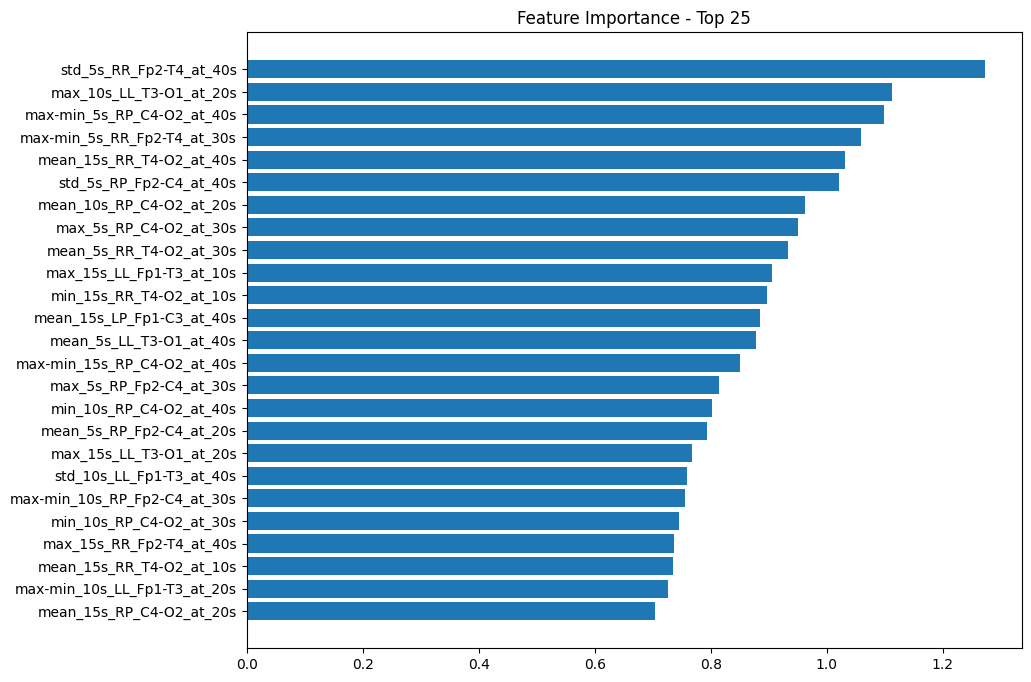

In [17]:
TOP = 25

feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(10, 8))
plt.barh(np.arange(len(sorted_idx))[-TOP:], feature_importance[sorted_idx][-TOP:], align='center')
plt.yticks(np.arange(len(sorted_idx))[-TOP:], np.array(FEATURES)[sorted_idx][-TOP:])
plt.title(f'Feature Importance - Top {TOP}')
plt.show()

# CV Score for CatBoost
This is CV score for our CatBoost model.

In [18]:
import sys
sys.path.append('../input/kaggle-kl-div')
from kaggle_kl_div import score

oof = pd.DataFrame(all_oof.copy())
oof['id'] = np.arange(len(oof))

true = pd.DataFrame(all_true.copy())
true['id'] = np.arange(len(true))

oof.head()

,0,1,2,3,4,5,id
0,0.162791,0.161741,0.098894,0.051881,0.101265,0.423429,0
1,0.162791,0.161741,0.098894,0.051881,0.101265,0.423429,1
2,0.162791,0.161741,0.098894,0.051881,0.101265,0.423429,2
3,0.162791,0.161741,0.098894,0.051881,0.101265,0.423429,3
4,0.162791,0.161741,0.098894,0.051881,0.101265,0.423429,4


In [19]:
true.head()

,0,1,2,3,4,5,id
0,0.055556,0.000000,0.0,0.000000,0.000000,0.944444,0
1,0.000000,0.000000,0.0,0.500000,0.000000,0.500000,1
2,0.000000,0.111111,0.0,0.000000,0.000000,0.888889,2
3,0.600000,0.200000,0.2,0.000000,0.000000,0.000000,3
4,0.000000,0.000000,0.0,0.066667,0.333333,0.600000,4


In [20]:
# TARGETSの各列を正規化
oof_data = oof[[0, 1, 2, 3, 4, 5]].values
oof_data = oof_data / oof_data.sum(axis=1,keepdims=True)
oof[[0, 1, 2, 3, 4, 5]] = oof_data

In [21]:
oof.head()

,0,1,2,3,4,5,id
0,0.162791,0.161741,0.098894,0.051881,0.101265,0.423429,0
1,0.162791,0.161741,0.098894,0.051881,0.101265,0.423429,1
2,0.162791,0.161741,0.098894,0.051881,0.101265,0.423429,2
3,0.162791,0.161741,0.098894,0.051881,0.101265,0.423429,3
4,0.162791,0.161741,0.098894,0.051881,0.101265,0.423429,4


In [22]:
temp = pl.from_pandas(oof)

In [23]:
cv = score(solution=true, submission=oof, row_id_column_name='id')
print('CV Score KL-Div for CatBoost =',cv)

CV Score KL-Div for CatBoost = 1.2619397331915752


In [24]:
import sys
sys.path.append('../input/kaggle-kl-div')
from kaggle_kl_div import score

oof = pd.DataFrame(all_oof.copy())
oof['id'] = np.arange(len(oof))

true = pd.DataFrame(all_true.copy())
true['id'] = np.arange(len(true))

cv = score(solution=true, submission=oof, row_id_column_name='id')
print('CV Score KL-Div for CatBoost =',cv)

# CV Score KL-Divの保存
with open(f'models/CV_Score_v{VER}.txt', 'w') as f:
    f.write(str(cv) + "\n")

CV Score KL-Div for CatBoost = 1.2619397331915752
